# 用TFRecord读取mnist数据
https://blog.csdn.net/dbsdzxq/article/details/79872465

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline
import pickle
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## 先从pickle文件中读出数据

In [2]:
load_path = r'..\data\mnist\valid_mnist_c.pkl'
with open(load_path, 'rb') as in_f:
        data_dict = pickle.load(in_f)
        label = data_dict['label']
        img = data_dict['feature']
        ops = data_dict['ops']
num_examples = len(label)

In [3]:
label.shape

(5000, 10)

In [14]:
label[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [23]:
img[0].shape[0]

28

## 写进TFRecord

In [6]:
# 先写两个下面会用到的辅助函数

# 生成整数的属性
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
# 生成字符串型的属性
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [4]:
filenames = '../data/mnist/valid.tfrecord'
writer = tf.python_io.TFRecordWriter(filenames)

In [7]:
# 这里写进两个feature：img，label
for i in range(num_examples):
    image_raw = img[i].tobytes()  # 将图像转为字符串
    labels = label[i].tobytes()
    rows = img[i].shape[0]
    cols = img[i].shape[1]
    depth = img[i].shape[2]
    # 创建字典
    features={}
    features['labels'] = _bytes_feature(labels)
    features['image_raw'] = _bytes_feature(image_raw)
    features['height'] = _int64_feature(rows)
    features['width'] = _int64_feature(cols)
    features['depth'] = _int64_feature(depth)


    
    # 将存有所有feature的字典送入tf.train.Features中
    tf_features = tf.train.Features(feature= features)
    # 再将其变成一个样本example
    tf_example = tf.train.Example(features = tf_features)
    # 序列化该样本
    tf_serialized = tf_example.SerializeToString()
    # 写入一个序列化的样本
    writer.write(tf_serialized)
# 关闭文件    
writer.close()

## 从TFRecord中导出数据
    

In [8]:
filenames = ["output.tfrecord"]
dataset = tf.data.TFRecordDataset(filenames)

定义解析函数

In [38]:
def parse_function(example_proto):
    # 只接受一个输入：example_proto，也就是序列化后的样本tf_serialized
    dics = {# 这里没用default_value，随后的都是None
            'image_raw': tf.FixedLenFeature([], tf.string),
            'labels': tf.FixedLenFeature([], tf.string),
            'image_shape': tf.FixedLenFeature(shape=(3,),dtype=tf.int64)}
    
    parsed_example = tf.parse_single_example(example_proto, dics)
    # 得到的parsed_example也是一个字典，其中每个key是对应feature的名字，value是相应的feature解析值。
    # 解码字符
    parsed_example['image_raw'] = tf.decode_raw(parsed_example['image_raw'], tf.float32)
    parsed_example['labels'] = tf.decode_raw(parsed_example['labels'], tf.float64)
    
    # 改变形状
    parsed_example['image_raw'] = tf.reshape(parsed_example['image_raw'], [28,28,1])
    parsed_example['labels'] = tf.reshape(parsed_example['labels'], [10])
    
    # 返回所有feature
    return parsed_example

In [39]:
new_dataset = dataset.map(parse_function)

In [40]:
new_dataset

<MapDataset shapes: {image_raw: (28, 28, 1), image_shape: (3,), labels: (10,)}, types: {image_raw: tf.float32, image_shape: tf.int64, labels: tf.float64}>

In [30]:
new_dataset = dataset.map(parse_function)
shuffle_dataset = new_dataset.shuffle(buffer_size=num_examples * 1000)
batch_dataset = shuffle_dataset.batch(128)

创建迭代器

In [35]:
# 创建获取数据集中样本的迭代器
iterator = batch_dataset.make_one_shot_iterator()

In [36]:
# 获得下一个样本
next_element = iterator.get_next()
# 创建Session
sess = tf.InteractiveSession()
while True:
    # 不断的获得下一个样本
    try:
        # 获得的值直接属于graph的一部分，所以不再需要用feed_dict来喂
        labels, image = sess.run([next_element['labels'],
                               next_element['image_raw']])
                                             
    # 如果遍历完了数据集，则返回错误
    except tf.errors.OutOfRangeError:
        print("End of dataset")
        break

InvalidArgumentError: Feature: image_shape (data type: int64) is required but could not be found.
	 [[{{node ParseSingleExample/ParseSingleExample}} = ParseSingleExample[Tdense=[DT_STRING, DT_INT64, DT_STRING], dense_keys=["image_raw", "image_shape", "labels"], dense_shapes=[[], [3], []], num_sparse=0, sparse_keys=[], sparse_types=[]](arg0, ParseSingleExample/Const, ParseSingleExample/Const_1, ParseSingleExample/Const_2)]]
	 [[node IteratorGetNext_3 (defined at <ipython-input-36-d9b50da59b71>:2)  = IteratorGetNext[output_shapes=[[?,?,?,?], [?,3], [?,10]], output_types=[DT_FLOAT, DT_INT64, DT_DOUBLE], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_4)]]

In [37]:
image.shape

NameError: name 'image' is not defined

In [22]:
image_resized  = tf.image.resize_images(image, [96, 96])

In [23]:
image_resized

<tf.Tensor 'resize_images/ResizeBilinear:0' shape=(8, 96, 96, 1) dtype=float32>

In [43]:
new_img_PIL = transforms.ToPILImage()(image_resized).convert('RGB')

NameError: name 'transforms' is not defined

In [26]:
labels

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [27]:
labels.shape

(8, 10)

In [29]:
image.shape

(8, 28, 28, 1)

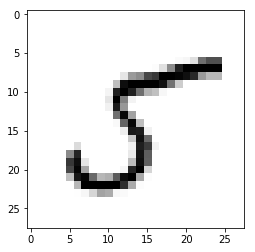

In [31]:
plt.imshow(image[0,:,:,0],cmap = 'binary')

Done!

In [30]:
from PIL import Image

In [33]:
pic = Image.open(r'..\20181229133402.jpg')

In [36]:
pic.size

(844, 844)

In [37]:
pic_resized = pic.resize((96,96))

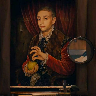

In [38]:
pic_resized

In [40]:
pic_resized = pic.resize((108,108))

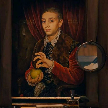

In [41]:
pic_resized

In [4]:
a = tuple((28,28,1))

In [5]:
a

(28, 28, 1)

In [6]:
b = list(a)

In [7]:
b

[28, 28, 1]